In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting as ni_plt
import scipy.spatial as spatial
import scipy.stats as stats
import nibabel as nib
import matplotlib as mpl

In [2]:
fig_dir = '../../paper/figs/source/best_locs'

In [3]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [4]:
fig_count = 0

In [5]:
r = 20

# PyFR analysis

In [6]:
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

In [7]:
pyFR_df['across'] = plot.r2z(pyFR_df['across'])
pyFR_df['within'] = plot.r2z(pyFR_df['within'])

In [8]:
grouped_pyfr_mean = pyFR_df.groupby('Subject')['across','within'].mean()

In [9]:
pyFR_df['Subject'].shape

(4168,)

## Replace correlation for each electrode with the average correlation for each subject 

In [10]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_pyfr_mean.index):


    sub_locs = plot.compile_df_locs(pyFR_df['R'][pyFR_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_pyfr_mean['across'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_pyfr_mean['across'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_pyfr_df = pd.DataFrame()
bestloc_pyfr_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_pyfr_df['Subject'] = subj_by_subject
bestloc_pyfr_df['R'] = None



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [11]:
# # This loop takes a while, so I saved the output and input it later to make it faster
# for i in range(bestloc_pyfr_df.shape[0]):
#     bestloc_pyfr_df['R'][i] = str(R_locs[i])

# bestloc_pyfr_df.to_csv(os.path.join(pyfr_data_dir, 'best_locs.csv'))

In [12]:
bestloc_pyfr_df = pd.read_csv(os.path.join(pyfr_data_dir, 'best_locs.csv'), index_col=0)

In [13]:
bestloc_pyfr_df.head()

,Correlation,Subject,R
0,0.684209,0,[42.42 -9.47 25.62]
1,0.684209,0,[ 40.4 10.97 -14.86]
2,0.684209,0,[ 35.35 -19.92 -40.48]
3,0.684209,0,[ 51.52 -22.65 -25.15]
4,0.684209,0,[ 54.55 -34.13 1.46]


In [14]:
bo_locs = plot.compile_df_locs(bestloc_pyfr_df[bestloc_pyfr_df['Subject']==0]['R'])
bo_corr = bestloc_pyfr_df[bestloc_pyfr_df['Subject']==0]['Correlation'].values

In [15]:
all_locs = plot.compile_df_locs(bestloc_pyfr_df['R'])
all_corr = np.atleast_2d(bestloc_pyfr_df['Correlation'])

## Plot patient average correlation at each electrode location

/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


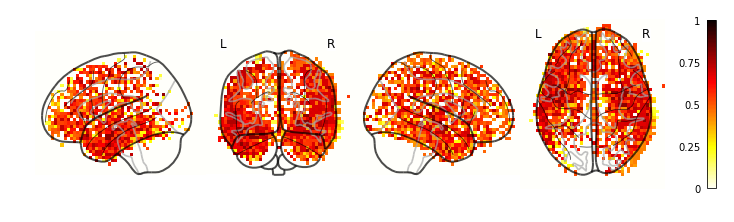

In [16]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=all_corr, locs=all_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [17]:
bestloc_pyfr_df.head()

,Correlation,Subject,R
0,0.684209,0,[42.42 -9.47 25.62]
1,0.684209,0,[ 40.4 10.97 -14.86]
2,0.684209,0,[ 35.35 -19.92 -40.48]
3,0.684209,0,[ 51.52 -22.65 -25.15]
4,0.684209,0,[ 54.55 -34.13 1.46]


In [18]:
bestloc_pyfr_df['Correlation'].mean()

0.5051086136960115

## most informative location within radius

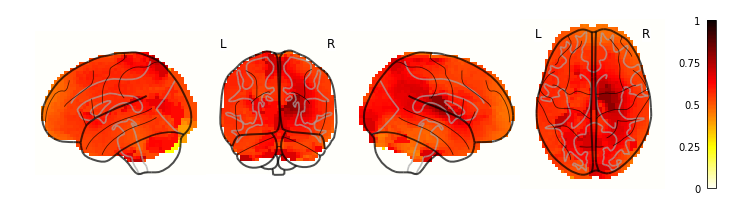

In [19]:
plot.most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=r)

In [20]:
most_info_pyfr = plot.most_informative_locs(bestloc_pyfr_df, vox_size=4, width=r)

# RAM

In [21]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)

## FR

In [22]:
str_find = '_FR1'
str_find
FR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [23]:
fr_locs = plot.compile_df_locs(FR_df['R'])

In [24]:
fr_subject = np.array([])
fr_within = np.array([])
fr_across = np.array([])
fr_R = np.array([])
for i , item in enumerate(FR_df['Subject'].values):
    fr_subject = np.append(fr_subject, item)
    fr_within = np.append(fr_within, FR_df['W_w_w'].iloc[i])
    fr_across = np.append(fr_across, FR_df['W_a_w'].iloc[i])
    fr_R = np.append(fr_R, FR_df['R'].iloc[i])

In [25]:
corr_fr_df = pd.DataFrame()
corr_fr_df['Subject'] = fr_subject
corr_fr_df['W_w_w'] = plot.r2z(fr_within)
corr_fr_df['W_a_w'] = plot.r2z(fr_across)
corr_fr_df['R'] = fr_R

In [26]:
fr_locs = plot.compile_df_locs(corr_fr_df['R'])

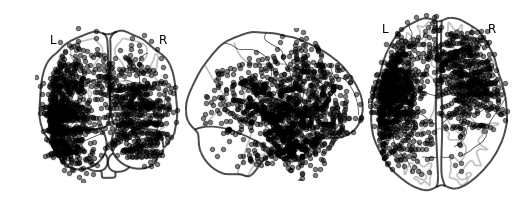

In [27]:
ni_plt.plot_connectome(np.eye(fr_locs.shape[0]), fr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None, 'cmap':'hot'},
                       node_size=20, node_color='k')

## CatFR

In [28]:
str_find = '_CatFR1'
str_find
CatFR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [29]:
catfr_subject = np.array([])
catfr_within = np.array([])
catfr_across = np.array([])
catfr_R = np.array([])
for i , item in enumerate(CatFR_df['Subject'].values):
    catfr_subject = np.append(catfr_subject, item)
    catfr_within = np.append(catfr_within, CatFR_df['W_w_w'].iloc[i])
    catfr_across = np.append(catfr_across, CatFR_df['W_a_w'].iloc[i])
    catfr_R = np.append(catfr_R, CatFR_df['R'].iloc[i])

In [30]:
corr_catfr_df = pd.DataFrame()
corr_catfr_df['Subject'] = catfr_subject
corr_catfr_df['W_w_w'] = plot.r2z(catfr_within)
corr_catfr_df['W_a_w'] = plot.r2z(catfr_across)
corr_catfr_df['R'] = catfr_R

In [31]:
catfr_locs = plot.compile_df_locs(corr_catfr_df['R'])

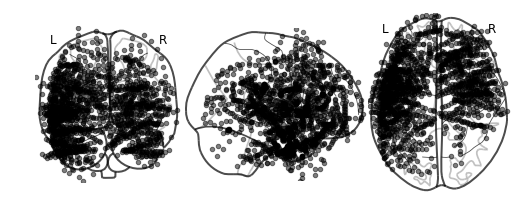

In [32]:
ni_plt.plot_connectome(np.eye(catfr_locs.shape[0]), catfr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None},
                       node_size=20, node_color='k')

## All within

In [33]:
all_subject = np.array([])
all_within = np.array([])
all_across = np.array([])
all_R = np.array([])
for i , item in enumerate(RAM_df['Subject'].values):
    #print(item.split('_')[0])
    all_subject = np.append(all_subject, item)
    all_within = np.append(all_within, RAM_df['W_w_w'].iloc[i])
    all_across = np.append(all_across, RAM_df['W_a_w'].iloc[i])
    all_R = np.append(all_R, RAM_df['R'].iloc[i])

In [34]:
corr_all_df = pd.DataFrame()
corr_all_df['Subject'] = all_subject
corr_all_df['W_w_w'] = plot.r2z(all_within)
corr_all_df['W_a_w'] = plot.r2z(all_across)
corr_all_df['R'] = all_R

In [35]:
grouped_all_mean = corr_all_df.groupby('Subject')['W_w_w','W_a_w'].mean()

In [36]:
grouped_all_mean.shape

(24, 2)

In [37]:
from scipy import stats
grouped_results = corr_all_df.groupby('Subject')['W_w_w', 'W_a_w'].mean()
t_stat_group = stats.ttest_rel(grouped_results['W_a_w'],grouped_results['W_w_w'])

In [38]:
t_stat_group

Ttest_relResult(statistic=6.930163974276389, pvalue=4.5901965099743084e-07)

In [39]:
grouped_results.head()

,W_w_w,W_a_w
Subject,,
0.0,0.219335,0.824195
1.0,0.086401,0.505154
2.0,0.091786,1.185209
3.0,0.089896,0.607879
4.0,0.412031,1.435772


## Replace correlation for each electrode with the average correlation for each subject 

In [40]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_all_mean.index):


    sub_locs = plot.compile_df_locs(corr_all_df['R'][corr_all_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_all_mean['W_a_w'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_all_mean['W_a_w'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_all_df = pd.DataFrame()
bestloc_all_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_all_df['Subject'] = subj_by_subject
bestloc_all_df['R'] = None



In [41]:
### this take a while, so I read it in instead
# for i in range(bestloc_all_df.shape[0]):
#     bestloc_all_df['R'][i] = str(R_locs[i])

# bestloc_all_df.to_csv(os.path.join(ram_data_dir, 'best_locs.csv'))

In [42]:
bestloc_all_df = pd.read_csv(os.path.join(ram_data_dir,'best_locs.csv'))

In [43]:
bestloc_all_df.head()

,Unnamed: 0,Correlation,Subject,R
0,0,0.677347,0.0,[-54.86 15.87 40.38]
1,1,0.677347,0.0,[-38.79 51.43 47.05]
2,2,0.677347,0.0,[-52.44 24.4 43.61]
3,3,0.677347,0.0,[-38.79 51.43 47.05]
4,4,0.677347,0.0,[-43.98 42.16 46.89]


In [44]:
bestloc_all_df['Correlation'].mean()

0.6241984368946204

In [45]:
all_ram_locs = plot.compile_df_locs(bestloc_all_df['R'])
all_ram_corr = np.atleast_2d(bestloc_all_df['Correlation'])

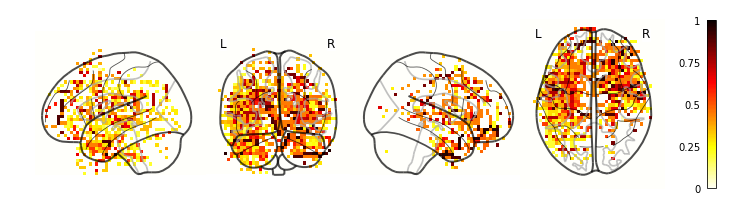

In [46]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=all_ram_corr, locs=all_ram_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

## most informative location within radius 

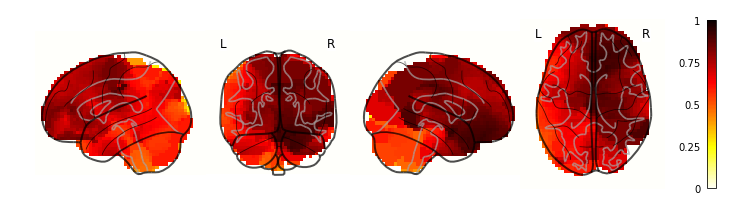

In [47]:
plot.most_informative_locs_plot(bestloc_all_df, vox_size=4, width=r)

In [48]:
most_info_all = plot.most_informative_locs(bestloc_all_df, vox_size=4, width=r)

## find intersection of best locations

In [49]:
best_locs_mask = pd.DataFrame()
best_locs_mask['RAM'] = most_info_all
best_locs_mask['PyFR'] = most_info_pyfr


In [50]:
## for fsl view overlay
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values
sub_nii.save(os.path.join(fig_dir, '4mm_brain.nii'))

In [51]:
pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 97)

ram_best = best_locs_mask['RAM']> np.percentile(best_locs_mask['RAM'].values, 97)

## top 97th percentile for pyfr

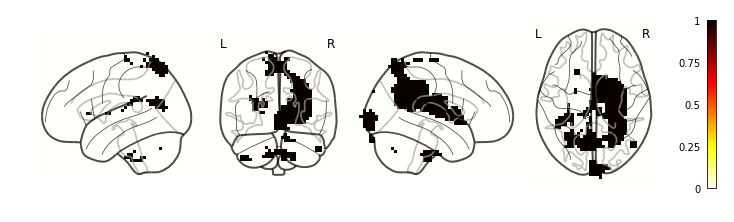

In [52]:
mask_nii = se.Brain(data=np.atleast_2d(pyfr_best), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

## top 97th percentile for ram

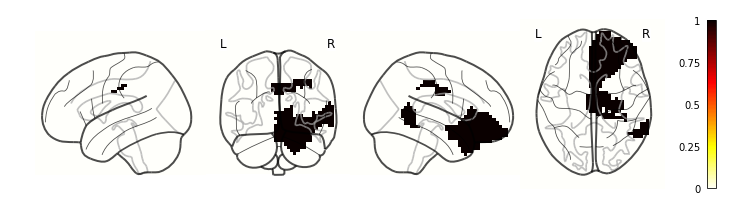

In [53]:
mask_nii = se.Brain(data=np.atleast_2d(ram_best), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

## find intersection of the two 

In [54]:
intersect = pyfr_best.astype('int64') + ram_best.astype('int64')

masked_best_locs = intersect>1

In [55]:
bo_nii_best = se.Brain(data=np.atleast_2d(masked_best_locs ), locs=sub_locs)

nii_bo_best = se.helpers._brain_to_nifti(bo_nii_best, sub_nii)

mask = nib.Nifti1Image(header=nii_bo_best.header, dataobj=np.squeeze(nii_bo_best.get_data()), affine=nii_bo_best.affine)

In [56]:
nii_bo_best.save(os.path.join(fig_dir, 'best_97th.nii'))

## top 90th percentile for paper figure

In [57]:
pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 90)

ram_best = best_locs_mask['RAM']> np.percentile(best_locs_mask['RAM'].values, 90)

In [58]:
intersect = pyfr_best.astype('int64') + ram_best.astype('int64')

masked_best_locs = intersect>1

In [59]:
bo_nii_best = se.Brain(data=np.atleast_2d(masked_best_locs ), locs=sub_locs)

nii_bo_best = se.helpers._brain_to_nifti(bo_nii_best, sub_nii)

mask = nib.Nifti1Image(header=nii_bo_best.header, dataobj=np.squeeze(nii_bo_best.get_data()), affine=nii_bo_best.affine)

In [60]:
nii_bo_best.save(os.path.join(fig_dir, 'best_90th.nii'))

## plot pyfr best locs and intersection

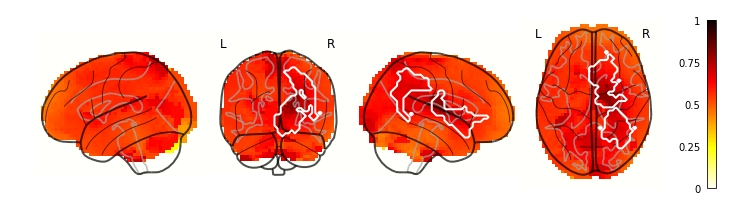

In [61]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
bo_nii = se.Brain(data=np.atleast_2d(most_info_pyfr), locs=sub_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
h = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
h.add_contours(mask, levels=[.5], colors='w', linewidths=2)
plt.savefig(outfile)

## plot ram best locs and intersection

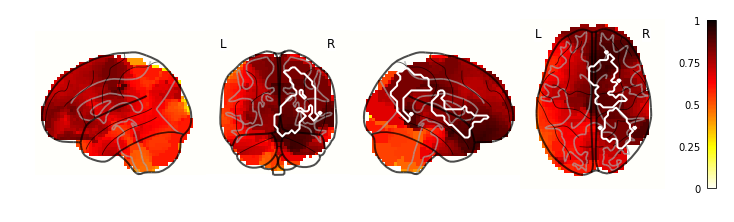

In [62]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
bo_nii = se.Brain(data=np.atleast_2d(most_info_all), locs=sub_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
h = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
h.add_contours(mask, levels=[.5], colors='w', linewidths=2)
plt.savefig(outfile)

## Scatter plot comparing pyfr and all ram

In [63]:
best_locs_df = pd.DataFrame()
best_locs_df['RAM'] = plot.r2z(most_info_all)
best_locs_df['PyFR'] = plot.r2z(most_info_pyfr)

best_locs_df = best_locs_df.replace(0,np.nan)
best_locs_df.dropna(inplace=True)

(0.2034910823253237, 2.808376580872638e-265)


<Figure size 1332x1332 with 0 Axes>

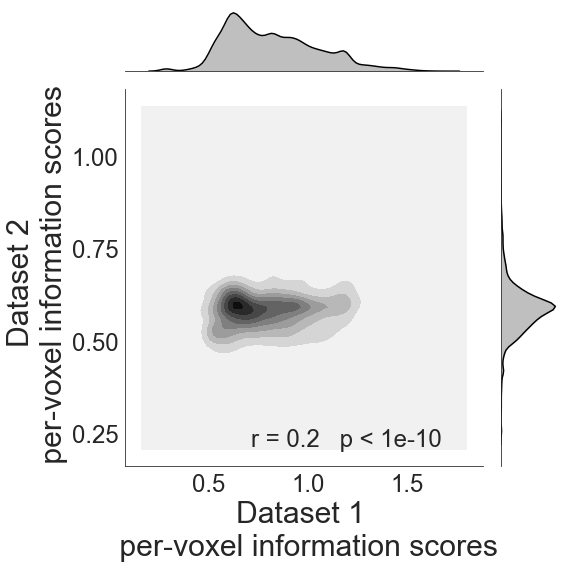

In [64]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_2d_corr_hist(best_locs_df, outfile=outfile)

## Plot the intersection over 4mm standard brain 

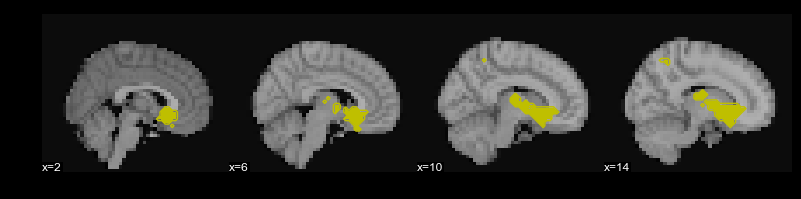

In [65]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
display = ni_plt.plot_anat(sub_nii, display_mode='x', cut_coords=[2, 6, 10, 14])
display.add_contours(mask, levels=[.5], filled=True, colors='y')
plt.savefig(outfile)

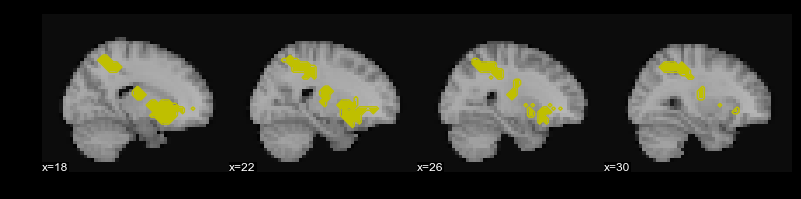

In [66]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
display = ni_plt.plot_anat(sub_nii, display_mode='x', cut_coords=[18, 22, 26, 30])
display.add_contours(mask, levels=[.5], filled=True, colors='y')
plt.savefig(outfile)